In [385]:
import glob
import os

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc


In [407]:
# Allocate the base directory of the data
base_dir = "/scratch/bvdberg/SoloTE/"

# Use glob to find directories matching the pattern
directories = glob.glob(
    os.path.join(base_dir, "run_*/", "*_SoloTE_output/", "*_locustes_MATRIX")
)
anndata = {}


In [408]:
for directory in directories:
    # Set the wildcard per directory
    wildcard = os.path.basename(directory)
    identifier = str(wildcard.split("_locustes_MATRIX")[0])
    
    # Skip directories with an empty identifier
    if not identifier:
        continue

    # Check if the required files exist in the directory
    matrix_file = os.path.join(directory, "matrix.mtx")
    barcodes_file = os.path.join(directory, "barcodes.tsv")
    features_file = os.path.join(directory, "features.tsv")

    if (
        os.path.exists(matrix_file)
        and os.path.exists(barcodes_file)
        and os.path.exists(features_file)
    ):
        # Create a new AnnData object for each directory
        adata = sc.AnnData()

        # Read the matrix using scanpy
        adata = sc.read_mtx(matrix_file)
        adata = adata.transpose()

        # Read barcodes and features using pandas
        barcodes = pd.read_csv(barcodes_file, sep="\t", header=None, names=["barcode"])
        features = pd.read_csv(features_file, sep="\t", header=None, names=["gene_name"])

        # Set obs_names and var_names
        adata.obs_names = barcodes["barcode"]
        adata.var_names = features["gene_name"]

        anndata[identifier] = adata

    else:
        print(f"Required files not found in directory: {directory}")


In [409]:
# Combine the adata sets to one data set with the Concatenate function, we use 'outer' to preserve as much data as possible. Missing variablles will become NaN values
combined_adata = ad.concat(anndata, label="dataset_origin", join="outer")


/mbshome/bvdberg/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [410]:
# Modify the data to make it comparable to a whitelisted h5ad formatted file, by manipulating the 'dataset origin' column
combined_adata.obs.index = combined_adata.obs['dataset_origin'].str[1:] + '_' + combined_adata.obs.index


In [255]:
combined_adata.write_h5ad("combined_bonemarrow_sets.h5ad")


In [402]:
whitelist_anndata = ad.read_h5ad("bonemarrow_m.h5ad")


In [403]:
whitelist_anndata

AnnData object with n_obs × n_vars = 14434 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'sampleID', 'tissue', 'model', 'age', 'model_age', 'mouseID', 'doublet_scores', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.hist', 'S.Score', 'G2M.Score', 'group_umap_sub', 'annotation_lv0', 'annotation_lv1', 'annotation_lv2', 'annotation_lv3', 'phase'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_tsne', 'X_umap', 'X_umap_sub', 'X_umap_tissue'

In [411]:
# Identify the common indices between combined_adata and whitelist_anndata
common_indices = combined_adata.obs.index.intersection(whitelist_anndata.obs.index)

# Filter combined_adata based on the common indices
filtered_anndata = combined_adata[combined_adata.obs.index.isin(common_indices)]

# Reindex the filtered_anndata with the order of the whitelist_anndata indices
filtered_anndata.obs = whitelist_anndata.obs.reindex(filtered_anndata.obs.index)

/mbshome/bvdberg/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


# Subset the anndata based on the whitelist
# use isin instead of str.contains if contains breaks
filtered_anndata = combined_adata[combined_adata.obs.index.isin(whitelist_anndata.obs.index)]


In [412]:
filtered_anndata

AnnData object with n_obs × n_vars = 14434 × 26031
    obs: 'nCount_RNA', 'nFeature_RNA', 'sampleID', 'tissue', 'model', 'age', 'model_age', 'mouseID', 'doublet_scores', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.hist', 'S.Score', 'G2M.Score', 'group_umap_sub', 'annotation_lv0', 'annotation_lv1', 'annotation_lv2', 'annotation_lv3', 'phase'

In [413]:
for i in filtered_anndata.var_names:
    if i.startswith('SoloTE'):
        print (i)



SoloTE|AmnSINE1
SoloTE|AmnSINE2
SoloTE|Arthur1
SoloTE|Arthur1A
SoloTE|Arthur1B
SoloTE|Arthur1C
SoloTE|B1F
SoloTE|B1F1
SoloTE|B1F2
SoloTE|B1_Mm
SoloTE|B1_Mur1
SoloTE|B1_Mur2
SoloTE|B1_Mur3
SoloTE|B1_Mur4
SoloTE|B1_Mus1
SoloTE|B1_Mus2
SoloTE|B2_Mm1a
SoloTE|B2_Mm1t
SoloTE|B2_Mm2
SoloTE|B3
SoloTE|B3A
SoloTE|B4
SoloTE|B4A
SoloTE|BGLII
SoloTE|BGLII_A
SoloTE|BGLII_B
SoloTE|BGLII_B2
SoloTE|BGLII_C
SoloTE|BGLII_Mur
SoloTE|BGLII_Mus
SoloTE|BLACKJACK
SoloTE|CR1_Mam
SoloTE|Chap1_Mam
SoloTE|Charlie1
SoloTE|Charlie10
SoloTE|Charlie10a
SoloTE|Charlie10b
SoloTE|Charlie11
SoloTE|Charlie12
SoloTE|Charlie13a
SoloTE|Charlie13b
SoloTE|Charlie14a
SoloTE|Charlie15a
SoloTE|Charlie15b
SoloTE|Charlie16a
SoloTE|Charlie17
SoloTE|Charlie17a
SoloTE|Charlie17b
SoloTE|Charlie18a
SoloTE|Charlie19a
SoloTE|Charlie1a
SoloTE|Charlie1b
SoloTE|Charlie20a
SoloTE|Charlie21a
SoloTE|Charlie22a
SoloTE|Charlie23a
SoloTE|Charlie24
SoloTE|Charlie25
SoloTE|Charlie26a
SoloTE|Charlie29a
SoloTE|Charlie2a
SoloTE|Charlie2b
SoloTE|Charlie

In [396]:
filtered_anndata

AnnData object with n_obs × n_vars = 14434 × 25004
    obs: 'nCount_RNA', 'nFeature_RNA', 'sampleID', 'tissue', 'model', 'age', 'model_age', 'mouseID', 'doublet_scores', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.hist', 'S.Score', 'G2M.Score', 'group_umap_sub', 'annotation_lv0', 'annotation_lv1', 'annotation_lv2', 'annotation_lv3', 'phase'

# Copy metadata from the whitelist to the filtered dataset
filtered_anndata.obs = whitelist_anndata.obs.copy()
# try to keep index order of the whitelist the same!!!!!


In [260]:
# Initialize the 'te_type' column
filtered_anndata.var['te_type'] = 'GENE'

# Create a mask based on the structure of the TE entries
mask = filtered_anndata.var_names.str.count(':') > 1

# Search entries corresponding to the mask and add the te type from the entry
matching_entries = filtered_anndata.var_names[mask]
matching_entries = matching_entries.astype(str).str.split(':').str[2]
matching_entries = matching_entries.str.split('|').str[0]

# Update the 'te_type' with the matching entires
filtered_anndata.var['te_type'][mask] = matching_entries


In [261]:
# Save the data
filtered_anndata.write_h5ad("whitelisted_bonemarrow.h5ad")


/mbshome/bvdberg/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


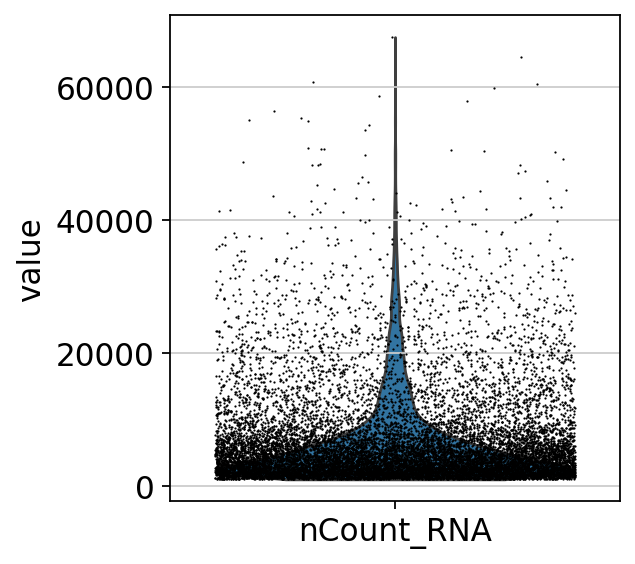

In [395]:
sc.pl.violin(whitelist_anndata, "nCount_RNA", jitter=0.4)


In [ ]:
# noparam18 = 18807.99 MB
# param18 = 18884.18 MB 
# noparam31 = 
# param31 = 17903.01 MB


In [230]:
bar018 = "/scratch/bvdberg/SoloTE/run_A021/A021_SoloTE_output/A021_familytes_MATRIX//barcodes.tsv"
feat018 = "/scratch/bvdberg/SoloTE/run_A021/A021_SoloTE_output/A021_familytes_MATRIX//features.tsv"
matrix018 = "/scratch/bvdberg/SoloTE/run_A021/A021_SoloTE_output/A021_familytes_MATRIX//matrix.mtx"
noparambar018 = "/scratch/bvdberg/SoloTE/noparam021/noparam021_SoloTE_output/noparam021_familytes_MATRIX/barcodes.tsv"
noparamfeat018 = "/scratch/bvdberg/SoloTE/noparam021/noparam021_SoloTE_output/noparam021_familytes_MATRIX//features.tsv"
noparammatrix018 = "/scratch/bvdberg/SoloTE/noparam021/noparam021_SoloTE_output/noparam021_familytes_MATRIX//matrix.mtx"
bar031 = "/scratch/bvdberg/SoloTE/run_A031/A031_SoloTE_output/A031_familytes_MATRIX/barcodes.tsv"
feat031 = "/scratch/bvdberg/SoloTE/run_A031/A031_SoloTE_output/A031_familytes_MATRIX/features.tsv"
matrix031 = "/scratch/bvdberg/SoloTE/run_A031/A031_SoloTE_output/A031_familytes_MATRIX/matrix.mtx"
noparambar031 = "/scratch/bvdberg/SoloTE/noparam031/noparam031_SoloTE_output/noparam031_familytes_MATRIX/barcodes.tsv"
noparamfeat031 = "/scratch/bvdberg/SoloTE/noparam031/noparam031_SoloTE_output/noparam031_familytes_MATRIX//features.tsv"
noparammatrix031 = "/scratch/bvdberg/SoloTE/noparam031/noparam031_SoloTE_output/noparam031_familytes_MATRIX/matrix.mtx"


In [231]:
# Read the matrix using scanpy
A021 = sc.read_mtx(matrix018)
A021 = A021.transpose()

# Read barcodes and features using pandas 
barcodes = pd.read_csv(bar018, sep="\t", header=None, names=["barcode"])
features = pd.read_csv(feat018, sep="\t", header=None, names=["gene_name"])

# Set obs_names and var_names
A021.obs_names = barcodes["barcode"]
A021.var_names = features["gene_name"]


In [318]:
A021.var


""
gene_name
0610009B22Rik
0610009E02Rik
0610009L18Rik
0610010F05Rik
0610010K14Rik
...
SoloTE|hAT
SoloTE|hAT-Blackjack
SoloTE|hAT-Charlie


In [220]:
# Read the matrix using scanpy
NP_A021 = sc.read_mtx(noparammatrix018)
NP_A021 = NP_A021.transpose()

# Read barcodes and features using pandas
barcodes = pd.read_csv(noparambar018, sep="\t", header=None, names=["barcode"])
features = pd.read_csv(noparamfeat018, sep="\t", header=None, names=["gene_name"])

# Set obs_names and var_names
NP_A021.obs_names = barcodes["barcode"]
NP_A021.var_names = features["gene_name"]


In [140]:
NP_A021


AnnData object with n_obs × n_vars = 105194 × 110977

In [232]:
# Read the matrix using scanpy
A031 = sc.read_mtx(matrix031)
A031 = A031.transpose()

# Read barcodes and features using pandas
barcodes = pd.read_csv(bar031, sep="\t", header=None, names=["barcode"])
features = pd.read_csv(feat031, sep="\t", header=None, names=["gene_name"])

# Set obs_names and var_names
A031.obs_names = barcodes["barcode"]
A031.var_names = features["gene_name"]


In [121]:
A031


AnnData object with n_obs × n_vars = 100751 × 95480

In [233]:
# Read the matrix using scanpy
NP_A031 = sc.read_mtx(noparammatrix031)
NP_A031 = NP_A031.transpose()

# Read barcodes and features using pandas
barcodes = pd.read_csv(noparambar031, sep="\t", header=None, names=["barcode"])
features = pd.read_csv(noparamfeat031, sep="\t", header=None, names=["gene_name"])

# Set obs_names and var_names
NP_A031.obs_names = barcodes["barcode"]
NP_A031.var_names = features["gene_name"]


In [123]:
NP_A031


AnnData object with n_obs × n_vars = 101607 × 95795

In [329]:
TE_A021 = A021.var_names.str.count('olo')
TE_NP_A021 = NP_A021.var_names.str.count('olo')
TE_A031 = A031.var_names.str.count('olo')
TE_NP_A031 = NP_A031.var_names.str.count('olo')


In [330]:
NP_A021.var


""
gene_name
0610009B22Rik
0610009E02Rik
0610009L18Rik
0610010F05Rik
0610010K14Rik
...
SoloTE|hAT
SoloTE|hAT-Blackjack
SoloTE|hAT-Charlie


In [331]:
TE_A021


Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       ...
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype='int64', name='gene_name', length=18405)

In [332]:
print ("A021: ",TE_A021.value_counts(normalize=True).mul(100).round(1).astype(str) + '%',"\n",TE_A021.value_counts())
print ("\n")
print ("No parameters A021: ",TE_NP_A021.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print ("\n")
print ("A031: ",TE_A031.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print ("\n")
print ("No parameters A031: ",TE_NP_A031.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')


A021:  gene_name
0    99.8%
1     0.2%
Name: proportion, dtype: object 
 gene_name
0    18373
1       32
Name: count, dtype: int64


No parameters A021:  gene_name
0    99.8%
1     0.2%
Name: proportion, dtype: object


A031:  gene_name
0    99.8%
1     0.2%
Name: proportion, dtype: object


No parameters A031:  gene_name
0    99.8%
1     0.2%
Name: proportion, dtype: object


In [333]:
print ("A021: ",TE_A021.value_counts())
print ("\n")
print ("No parameters A021: ",TE_NP_A021.value_counts())
print ("\n")
print ("A031: ",TE_A031.value_counts())
print ("\n")
print ("No parameters A031: ",TE_NP_A031.value_counts())


A021:  gene_name
0    18373
1       32
Name: count, dtype: int64


No parameters A021:  gene_name
0    18507
1       32
Name: count, dtype: int64


A031:  gene_name
0    18298
1       31
Name: count, dtype: int64


No parameters A031:  gene_name
0    18397
1       31
Name: count, dtype: int64
